In [1]:
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten 
from keras.optimizers import Adam 
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers.schedules import ExponentialDecay 
import cv2 
import numpy as np
import os
import shutil
from glob import glob
from sklearn.metrics import f1_score

In [20]:
train_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

In [21]:
data_dir = 'db_for_cnn/train'
minority_class_dir = 'db_for_cnn/train/1 frustration'
majority_class_dir = 'db_for_cnn/train/0 neutral'
augmented_minority_dir = 'db_for_cnn/train/augmented_data'
os.makedirs(augmented_minority_dir, exist_ok=True)

In [22]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [23]:
minority_images = glob(os.path.join(minority_class_dir, '*.jpg'))
majority_count = len((os.listdir(majority_class_dir)))

In [24]:

minority_count = len(minority_images)
needed_count = majority_count - minority_count

In [25]:
needed_count

7320

In [27]:
train_generator = train_data_gen.flow_from_directory(
    'db_for_cnn/train',
    target_size=(64,64),
    batch_size=64,
    color_mode="grayscale",
    class_mode="binary"
)


Found 206520 images belonging to 3 classes.


In [40]:
# for img_path in minority_images:
#     img = tf.keras.preprocessing.image.load_img(img_path)
#     x = tf.keras.preprocessing.image.img_to_array(img)
#     x = np.expand_dims(x, axis=0)

#     i = 0
#     for batch in datagen.flow(x, batch_size=1, save_to_dir=augmented_minority_dir, save_prefix='aug', save_format='jpg'):
#         i += 1
#         if i >= needed_count // minority_count:
#             break

In [28]:
validation_generator = validation_data_gen.flow_from_directory(
    'db_for_cnn/dev',
    target_size=(64,64),
    batch_size=64,
    color_mode="grayscale",
    class_mode="binary"
)

Found 39780 images belonging to 2 classes.


In [29]:
test_generator = test_data_gen.flow_from_directory(
    'db_for_cnn/test',
    target_size=(64,64),
    batch_size=64,
    color_mode="grayscale",
    class_mode="binary"
)

Found 39840 images belonging to 2 classes.


Indices para las clases de Train



In [30]:
class_indices = train_generator.class_indices
print('Train classes:', class_indices)

Train classes: {'0 neutral': 0, '1 frustration': 1, 'augmented_data': 2}


Indices para las clases de Test



In [31]:
class_indices = test_generator.class_indices
print('Test classes:', class_indices)

Test classes: {'0 neutral': 0, '1 frustration': 1}


Indices para las clases de Validation


In [32]:
class_indices = validation_generator.class_indices
print('Val classes:', class_indices)

Val classes: {'0 neutral': 0, '1 frustration': 1}


In [35]:
model = Sequential() 

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 1))) 
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25)) 

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25)) 

model.add(Flatten()) 
model.add(Dense(1024, activation='relu')) 
model.add(Dropout(0.2)) 
model.add(Dense(1, activation='sigmoid')) 

model.summary() 

cv2.ocl.setUseOpenCL(False) 

initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=100000,decay_rate=0.96) 

optimizer = Adam(learning_rate=lr_schedule) 

model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 30, 30, 64)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 128)      0         
 g2D)                                                 

In [36]:
history = model.fit_generator( 
        train_generator, 
        steps_per_epoch=28709 // 64, 
        epochs=10, 
        validation_data=validation_generator, 
        validation_steps=7178 // 64)

Epoch 1/10


C:\Users\bl4ck\AppData\Local\Temp\ipykernel_29704\2726110189.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


448/448 [==============================] - 168s 374ms/step - loss: 0.6205 - accuracy: 0.6458 - val_loss: 0.5258 - val_accuracy: 0.7444
Epoch 2/10
448/448 [==============================] - 161s 358ms/step - loss: 0.4924 - accuracy: 0.7611 - val_loss: 0.5293 - val_accuracy: 0.7395
Epoch 3/10
448/448 [==============================] - 153s 342ms/step - loss: 0.3984 - accuracy: 0.8223 - val_loss: 0.3189 - val_accuracy: 0.8735
Epoch 4/10
448/448 [==============================] - 149s 333ms/step - loss: 0.3493 - accuracy: 0.8500 - val_loss: 0.4044 - val_accuracy: 0.8304
Epoch 5/10
448/448 [==============================] - 147s 328ms/step - loss: 0.3113 - accuracy: 0.8710 - val_loss: 0.3408 - val_accuracy: 0.8634
Epoch 6/10
448/448 [==============================] - 146s 326ms/step - loss: 0.2764 - accuracy: 0.8862 - val_loss: 0.2437 - val_accuracy: 0.8993
Epoch 7/10
448/448 [==============================] - 146s 325ms/step - loss: 0.2619 - accuracy: 0.8964 - val_loss: 0.2414 - val_accura

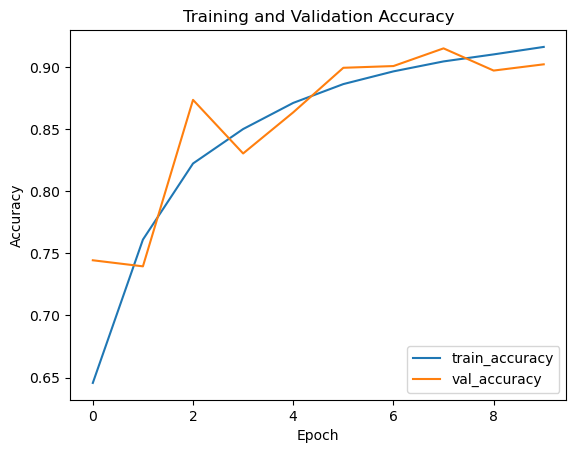

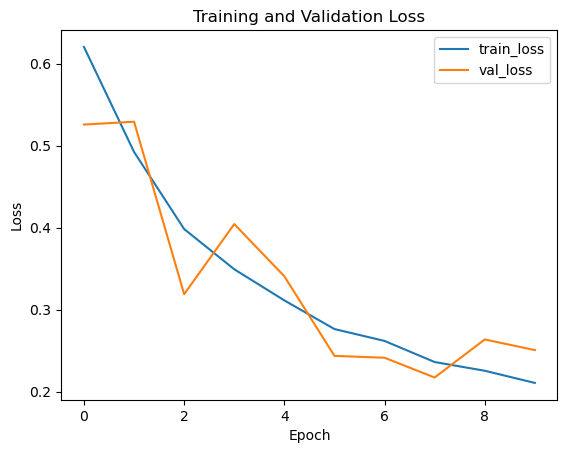

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [113]:
model.save('experimento-11.h5')

In [54]:
test_pred_path = 'db_for_cnn/test/1 frustration/11_6_3-12-23.jpg'
image = cv2.imread(test_pred_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
image_normalized = image / 255.0
image_batch = np.expand_dims(image_normalized, axis=0)

In [55]:
image_normalized.shape

(64, 64)

In [117]:
import tensorflow as tf

In [118]:
model = tf.keras.models.load_model('experimento-11.h5')

In [56]:
predictions = model.predict(image_batch)

1/1 [==============================] - 0s 92ms/step


In [57]:
predicted_class = np.argmax(predictions, axis=1)

In [58]:
print('Clase predicha:', predicted_class)

Clase predicha: [1]


In [59]:
predictions = model.predict(test_generator)

623/623 [==============================] - 45s 73ms/step


In [60]:
predicted_labels = np.argmax(predictions, axis=1)

In [61]:
for i in range(len(predicted_labels)):
    print(f"Muestra {i+1}:")
    print("Predicción:", predicted_labels[i], "(", predictions[i][predicted_labels[i]], ")")
    print("Etiqueta real:", test_generator.labels[i])
    print()

Muestra 1:
Predicción: 0 ( 0.99276066 )
Etiqueta real: 0

Muestra 2:
Predicción: 1 ( 0.9870429 )
Etiqueta real: 0

Muestra 3:
Predicción: 1 ( 0.64806944 )
Etiqueta real: 0

Muestra 4:
Predicción: 0 ( 0.9999399 )
Etiqueta real: 0

Muestra 5:
Predicción: 0 ( 0.98374605 )
Etiqueta real: 0

Muestra 6:
Predicción: 0 ( 0.96353203 )
Etiqueta real: 0

Muestra 7:
Predicción: 0 ( 0.71275884 )
Etiqueta real: 0

Muestra 8:
Predicción: 0 ( 0.66509634 )
Etiqueta real: 0

Muestra 9:
Predicción: 0 ( 0.99675685 )
Etiqueta real: 0

Muestra 10:
Predicción: 0 ( 0.9994747 )
Etiqueta real: 0

Muestra 11:
Predicción: 0 ( 0.9903734 )
Etiqueta real: 0

Muestra 12:
Predicción: 0 ( 0.69065446 )
Etiqueta real: 0

Muestra 13:
Predicción: 1 ( 0.91281766 )
Etiqueta real: 0

Muestra 14:
Predicción: 0 ( 0.9997167 )
Etiqueta real: 0

Muestra 15:
Predicción: 0 ( 0.99842644 )
Etiqueta real: 0

Muestra 16:
Predicción: 0 ( 0.974686 )
Etiqueta real: 0

Muestra 17:
Predicción: 0 ( 0.943664 )
Etiqueta real: 0

Muestra 18:
Pre

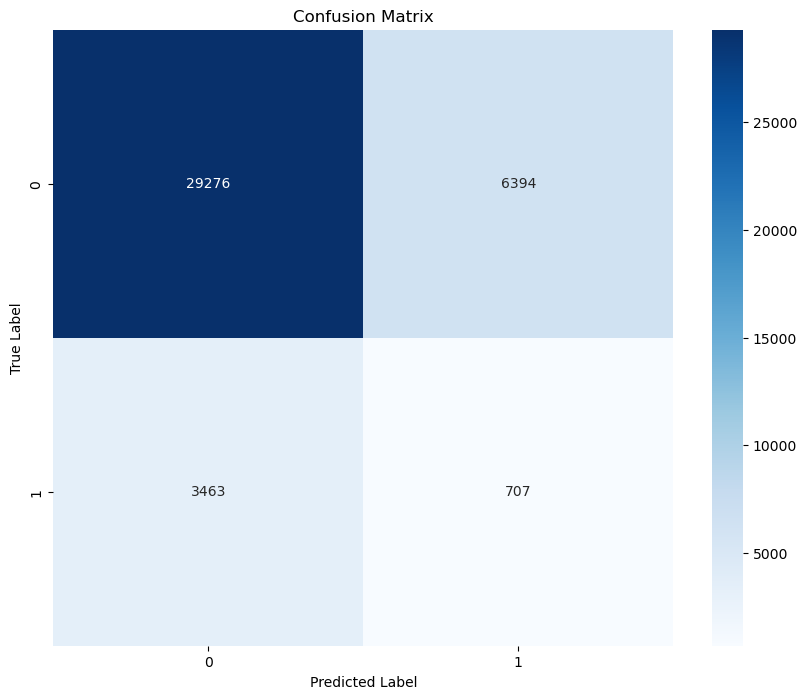

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generar la matriz de confusión
conf_matrix = confusion_matrix(a, predicted_labels)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(2), yticklabels=np.arange(2))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [65]:
a = test_generator.labels.astype('int64')

In [148]:
a

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [143]:
predicted_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [68]:
predicted_labels = (predictions > 0.5).astype(int).flatten()

In [70]:
f1 = f1_score(a, predicted_labels)
print(f'F1 Score: {f1}')

ValueError: Found input variables with inconsistent numbers of samples: [39840, 79680]